<a href="https://colab.research.google.com/github/ITALOZDKJ/Me-tornando-um-analista-de-dados/blob/main/Comparativo_de_investimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando bibliotecas

In [1]:
!pip install yfinance
import pandas as pd
import numpy as np
import pandas_datareader as web
import yfinance as yf
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt


     |████████████████████████████████| 6.4 MB 9.4 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


# Criando funções

### A seguir, temos uma função que cria features mais básicas, partindo das já disponíveis nos dados importados.

In [2]:
def features_initial(x):
    x.reset_index(inplace=True)
    x['Day'] = x['Date'].dt.day
    x['Month'] = x['Date'].dt.month
    x['Year'] = x['Date'].dt.year
    x['Year-Month'] = x['Date'].dt.strftime('%Y') +'-' + x['Date'].dt.strftime('%m') 
    x['Rentability%'] = round((x['Close']/x['Close'].shift()) * 100 -100, 2)
    x['Rentability pure'] = round(x['Close'] - x['Close'].shift(),2)

### Já a função abaixo, cria features um pouco mais elaboradas, nos permitindo simular um investimento feito de forma mensal e consistente, no período dos dados extraídos.

Com ela, conseguiremos informações como a quantidade de cotas totais em cada período, dividendos totais recebidos,
total de patrimônio acumuldado considerando a valorização do ativo e os dividendos recebidos ao longo do tempo.

In [49]:
def features_cash(x, y, aporte=100):
    x['Action_value'] = (x.loc[:,'High']+ x.loc[:,'Low'])/2
    year_temp = 0
    # 
    for year in list(x['Year'].unique()):
        year_temp = x.loc[(x['Year']==year)]
        for month in list(year_temp['Month'].unique()):
            temp = x.loc[(x['Month'] == month) & (x['Year']==year)]
            day = list(temp[0:]['Day'])
            day = day[0]
            x.loc[(x['Day'] == day) & (x['Month'] == month) & (x['Year'] == year),['Bougth']] = aporte
    # Valor de aporte
    x.loc[:,'Valor_aportado'] = x['Bougth'] * x['Action_value']
    x.fillna(0, inplace=True)
    # A soma das ações
    x['Total_actions'] = 0
    for pos,c in enumerate(x['Bougth']):
        x.loc[pos,'Total_actions'] = x.loc[:pos,'Bougth'].sum()
    
    # A soma do valor investido 
    x['Total_aportado'] = 0
    for pos,c in enumerate(x['Total_actions']):
        x.loc[pos,'Total_aportado'] = x.loc[:pos,'Valor_aportado'].sum()
        
    # The sum of dividends receives with actual aports
    x['Dividend_receive'] = x['Total_actions'] * x['Dividends']
    
    # The final dividends receives
    x['Total_receive'] = 0
    for pos,c in enumerate(x['Dividend_receive']):
        x.loc[pos,'Total_receive'] = x.loc[:pos,'Dividend_receive'].sum()

    x['Valor_atual'] = x['Total_actions'] * x['Close']


    x['My_rentability_pure'] = round(x['Valor_atual'] - x['Valor_atual'].shift(),2)

    x['yld_final'] = (x['Total_receive']/x['Total_aportado'])*100

def soma(x):
  x['Acumulatted'] = x['Valor_atual'] + x['Total_receive'] + x['Rentability pure']

## Importação de dados e aplicação das funções nos conjuntos de dados

In [32]:
ticket = yf.Ticker('TAEE4.SA')
bbseguros = yf.Ticker('BBSE3.SA')
itsa = yf.Ticker('ITSA4.SA')

In [33]:
taesa = ticket.history(interval='1d',start='2012-04-27', end='2022-04-27')
bbseguros = bbseguros.history(interval='1d',start='2012-04-27', end='2022-04-25')
itsa = itsa.history(interval='1d', start = '2012-04-27', end = '2022-04-27')

In [34]:
taesa_a = taesa.copy()
bbseguros_a = bbseguros.copy()
itsa_a = itsa.copy()
features_initial(taesa_a)
features_initial(bbseguros_a)
features_initial(itsa_a)

In [53]:
features_cash(bbseguros_a, bbseguros, aporte = 10)
features_cash(taesa_a, taesa, aporte=10)
features_cash(itsa_a, itsa, aporte=10)

In [54]:
soma(taesa_a)
soma(bbseguros_a)
soma(itsa_a)

In [68]:
taesa_a[taesa_a['Dividend_receive'] > 0][['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final', 'Dividend_receive']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final,Dividend_receive
881,9.541438,-2.51,2627.997544,-105.44,4102.818384,430,758.77397,4861.342354,28.872705,195.21140
901,10.050190,0.38,2725.943879,16.68,4422.083588,440,781.85637,5203.979958,28.682042,23.08240
992,12.402138,-1.59,3255.006922,-98.37,6077.047501,490,1048.28407,7125.131571,32.205279,266.42770
1002,12.542459,-0.07,3255.006922,-4.02,6145.805149,490,1269.49653,7415.291679,39.001347,221.21246
1140,11.950000,-2.56,4095.860704,-175.81,6691.999893,560,1552.88341,8244.573303,37.913482,283.38688


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

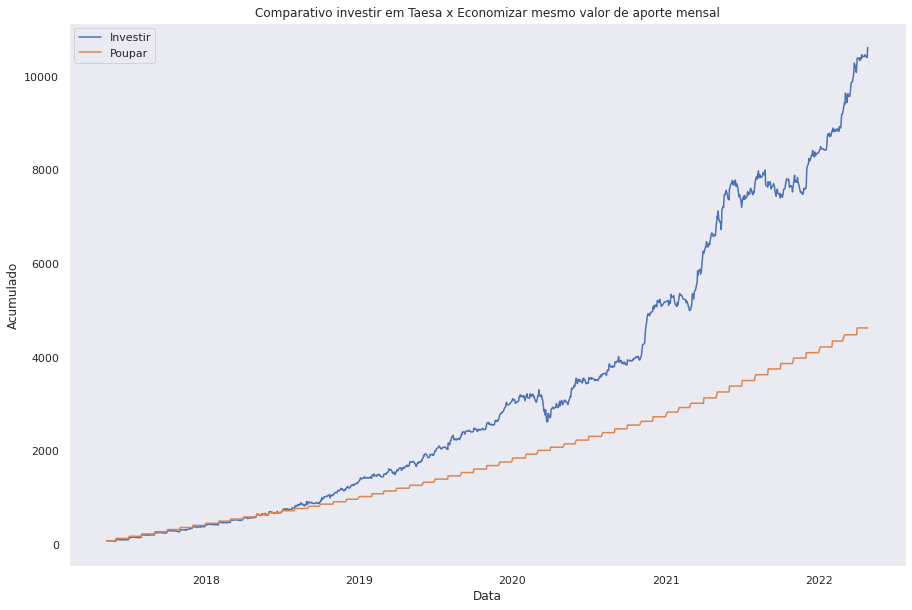

In [89]:
plt.figure(figsize=(15,10))
sns.set_theme(style="dark")
sns.lineplot(data = taesa_a, x='Date', y='Acumulatted')
sns.lineplot(data = taesa_a, x='Date', y='Total_aportado')
plt.title('Comparativo investir em Taesa x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')
plt.legend(labels=['Investir','Poupar'])

In [57]:
taesa_a['Rentability%'].sum()

89.37

In [63]:
bbseguros_a[bbseguros_a['Dividend_receive'] > 0][['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final', 'Dividend_receive']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final,Dividend_receive
1691,30.867140,-2.40,15606.164916,-630.95,25619.726048,830,7963.42142,33582.387468,51.027408,1585.99803
1814,25.016768,-3.47,17059.642047,-800.83,22264.923077,890,8742.39837,31006.421447,51.246083,778.97695
1936,26.293934,-0.55,18555.340097,-137.23,24979.237175,950,9194.71332,34173.810495,49.552923,452.31495
2059,20.102053,-1.32,19870.787755,-271.16,20303.073215,1010,9720.79606,30023.599275,48.920034,526.08274
2184,22.760000,-2.86,21087.635252,-716.85,24353.200245,1070,10715.94742,35068.477665,50.816259,995.15136


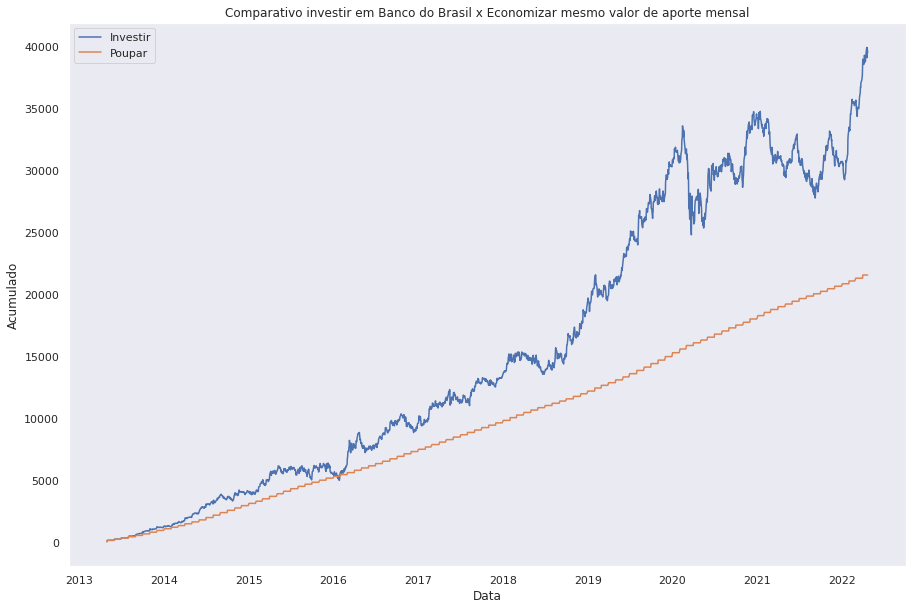

In [91]:
sns.set_theme(style="dark")
plt.figure(figsize=(15,10))
sns.lineplot(data = bbseguros_a, x='Date', y='Acumulatted')
sns.lineplot(data = bbseguros_a, x='Date', y='Total_aportado')
plt.title('Comparativo investir em Banco do Brasil x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')
plt.legend(labels=['Investir','Poupar'])

In [16]:
bbseguros_a['Rentability%'].sum()

49.099999999999994

In [65]:
itsa_a[itsa_a['Dividend_receive'] > 0][['Close','Rentability%', 'Total_aportado', 'My_rentability_pure', 'Valor_atual', 'Total_actions', 'Total_receive', 'Acumulatted', 'yld_final', 'Dividend_receive']].tail()

,Close,Rentability%,Total_aportado,My_rentability_pure,Valor_atual,Total_actions,Total_receive,Acumulatted,yld_final,Dividend_receive
2388,8.893706,0.77,7582.458597,79.62,10405.636396,1170,2976.18749,13381.893886,39.250956,26.21853
2410,9.399988,0.04,7670.449389,3.88,11091.986046,1180,3133.52869,14225.514736,40.851957,157.34120
2440,0.000000,0.00,7771.001671,-11748.80,0.000000,1200,3157.52869,3157.528690,40.632197,24.00000
2441,9.846700,0.00,7771.001671,11816.04,11816.039658,1200,3185.76349,15001.803148,40.995532,28.23480
2458,10.800000,-0.06,7771.001671,-7.96,12960.000229,1200,3321.80749,16281.797719,42.746195,136.04400


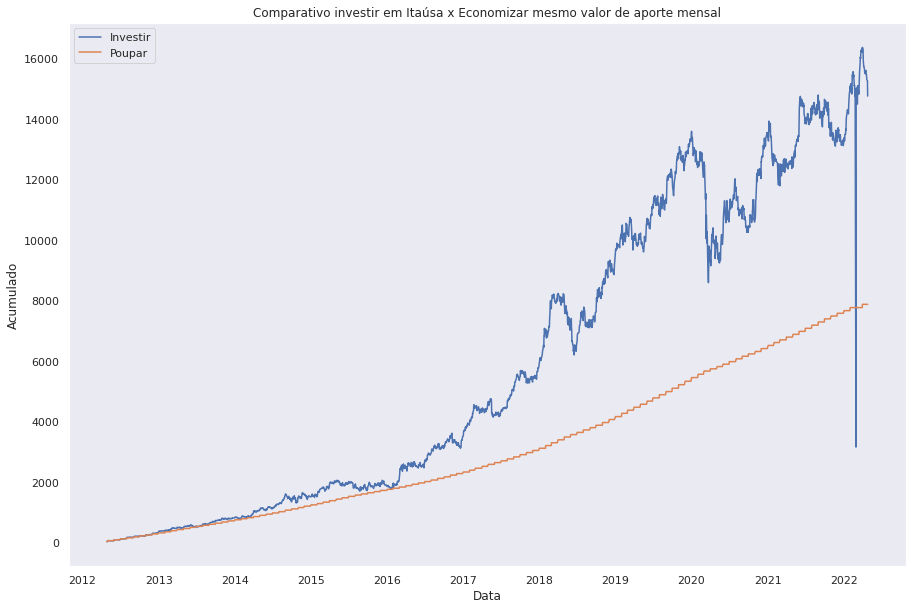

In [92]:
sns.set_theme(style="dark")
plt.figure(figsize=(15,10))
sns.lineplot(data = itsa_a, x='Date', y='Acumulatted')
sns.lineplot(data = itsa_a, x='Date', y='Total_aportado')
plt.title('Comparativo investir em Itaúsa x Economizar mesmo valor de aporte mensal')
plt.xlabel('Data')
plt.ylabel('Acumulado')
plt.legend(labels=['Investir','Poupar'])

In [20]:
itsa_a.head(1)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day,Month,...,Bougth,Valor_aportado,Total_actions,Total_aportado,Dividend_receive,Total_receive,Valor_atual,My_rentability_pure,yld_final,Acumulatted
0,2017-04-25,6.252381,6.317783,6.226221,6.311242,15940848.0,0.0,0.0,25,4,...,10.0,62.720016,10,62.720016,0.0,0.0,63.112421,NaN,0.0,63.112421


In [79]:
print(taesa_a['yld_final'].max())
print(itsa_a['yld_final'].max())
print(bbseguros_a['yld_final'].max())
print(taesa_a['Dividends'].max())
print(itsa_a['Dividends'].max())
print(bbseguros_a['Dividends'].max())
print(taesa_a['Dividend_receive'].max())
print(itsa_a['Dividend_receive'].max())
print(bbseguros_a['Dividend_receive'].max())

39.00134655941919
42.74619451367002
51.24608327614717
0.54373
0.579437
1.910841
283.38688
411.40027
1585.99803


In [80]:
taesa_a.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Day', 'Month', 'Year', 'Year-Month', 'Rentability%',
       'Rentability pure', 'Action_value', 'Bougth', 'Valor_aportado',
       'Total_actions', 'Total_aportado', 'Dividend_receive', 'Total_receive',
       'Valor_atual', 'My_rentability_pure', 'yld_final', 'Acumulatted'],
      dtype='object')

In [82]:
taesa_a[['Total_aportado','Valor_atual', 'Total_receive','yld_final', 'Acumulatted']].tail()

,Total_aportado,Valor_atual,Total_receive,yld_final,Acumulatted
1230,4623.8107,8897.999954,1552.88341,33.584494,10450.933364
1231,4623.8107,8910.000229,1552.88341,33.584494,10462.903639
1232,4623.8107,8873.999977,1552.88341,33.584494,10426.823387
1233,4623.8107,8850.000000,1552.88341,33.584494,10402.843410
1234,4623.8107,9065.999794,1552.88341,33.584494,10619.243204


In [83]:
itsa_a[['Total_aportado','Valor_atual', 'Total_receive','yld_final', 'Acumulatted']].tail()

,Total_aportado,Valor_atual,Total_receive,yld_final,Acumulatted
2474,7879.001673,12160.500231,3321.80749,42.160259,15482.197721
2475,7879.001673,12172.600508,3321.80749,42.160259,15494.417998
2476,7879.001673,11991.099815,3321.80749,42.160259,15312.757305
2477,7879.001673,11954.800138,3321.80749,42.160259,15276.577628
2478,7879.001673,11446.600046,3321.80749,42.160259,14767.987536


In [84]:
bbseguros_a[['Total_aportado','Valor_atual', 'Total_receive','yld_final', 'Acumulatted']].tail()

,Total_aportado,Valor_atual,Total_receive,yld_final,Acumulatted
2226,21569.385254,28514.399834,10715.94742,49.681283,39230.567254
2227,21569.385254,29190.200748,10715.94742,49.681283,39906.768168
2228,21569.385254,28361.800499,10715.94742,49.681283,39076.987919
2229,21569.385254,29168.400249,10715.94742,49.681283,39885.087669
2230,21569.385254,28765.099335,10715.94742,49.681283,39480.676755


#### Yld máx Taesa: 39%
#### Yld máx Itaúsa: 42%
#### Yld máx Banco do Brasil: 51%
#### Yld final Taesa: 33.58%
#### Yld final Itaúsa: 42.16%
#### Yld final Banco do Brasil: 49.58%
#### Dividendo máximo por ação Taesa: 0.54
#### Dividendo máximo por ação Itaúsa: 0.57
#### Dividendo máximo por ação Banco do Brasil: 1.91

